# Import data and libraries

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from data_experts.learning_functions import *

In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
df = pd.read_csv("../data/electronics_features_to_analyze.csv").drop("Unnamed: 0", axis = 1)

# Training Pipelines

In [ ]:
# Definir las características categóricas y numéricas
# Columnas numéricas
target = "sold_quantity"
numerical_features = [
    'price', 
    'initial_quantity',
    'available_quantity', 
    'sold_quantity', 
    'installment_quantity', 
    'installment_rate', 
    'days_until_discount_end', 
    'msi', 
    'discount'
]
numerical_features.remove(target)

# Columnas categóricas
categorical_features = [
    'buying_mode', 
    'query', 
    'condition', 
    'brand', 
    'domain_id', 
    'listing_type_id', 
    'is_official_store', 
    'free_shipping', 
    'store_pick_up'
]

# Definir las características y el target
X = df[numerical_features + categorical_features]
y = df[target]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Random Forest
rf_pipeline = build_pipeline(RandomForestRegressor(random_state=42), categorical_features, numerical_features)
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
rf_best_model, rf_grid_search = run_grid_search(rf_pipeline, rf_param_grid, X_train, y_train)
rf_results_df = calculate_and_compile_metrics("Random Forest", rf_best_model, X_train, X_test, y_train, y_test, rf_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [8]:
# XGBoost
xgb_pipeline = build_pipeline(XGBRegressor(random_state=42), categorical_features, numerical_features)
xgb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}
xgb_best_model, xgb_grid_search = run_grid_search(xgb_pipeline, xgb_param_grid, X_train, y_train)
xgb_results_df = calculate_and_compile_metrics("XGBoost", xgb_best_model, X_train, X_test, y_train, y_test, xgb_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [9]:
# LightGBM
lgbm_pipeline = build_pipeline(LGBMRegressor(random_state=42, verbose=-1), categorical_features, numerical_features)
lgbm_param_grid = {
    'model__num_leaves': [31, 50, 100],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300]
}
lgbm_best_model, lgbm_grid_search = run_grid_search(lgbm_pipeline, lgbm_param_grid, X_train, y_train)
lgbm_results_df = calculate_and_compile_metrics("LightGBM", lgbm_best_model, X_train, X_test, y_train, y_test, lgbm_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Buscar outliers en el training set pues no tiene sentido que el error se dispare para el trainingset

# Results and choosing the best model

In [27]:
def show_training(train_scores, test_scores):
    return pd.DataFrame([list(t) for t in zip(train_scores, test_scores)], columns = ["train", "test"])
pd.options.display.float_format = '{:,.2f}'.format

In [10]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['price', 'initial_quantity',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', RandomForestRegressor(random_state=42))])

In [39]:
rf_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,"780,095.14",883.23,77.72,0.99,"46,752.75",216.22,58.22,1.00,Random Forest,"{'model__max_depth': 30, 'model__min_samples_s..."


In [14]:
rf_param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (10, 30),
    'min_samples_split': (2, 10)
}

best_params_rf, train_scores_rf, test_scores_rf = bayesian_optimization(
    RandomForestRegressor, 
    rf_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features, numerical_features
)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -7.059e+0 | 17.49     | 9.606     | 246.4     |
| 2         | -4.75e+06 | 21.97     | 3.248     | 131.2     |
| 3         | -6.496e+0 | 11.16     | 8.929     | 220.2     |
| 4         | -4.874e+0 | 24.16     | 2.165     | 294.0     |
| 5         | -5.471e+0 | 26.65     | 3.699     | 136.4     |
| 6         | -4.673e+0 | 12.7      | 2.354     | 120.9     |
| 7         | -6.812e+0 | 30.0      | 7.69      | 110.9     |
| 8         | -5.245e+0 | 13.73     | 2.532     | 121.6     |
| 9         | -5.339e+0 | 10.33     | 2.0       | 119.4     |
| 10        | -5.27e+06 | 13.61     | 2.0       | 118.4     |
| 11        | -5.994e+0 | 23.96     | 5.408     | 131.4     |
| 12        | -4.725e+0 | 20.09     | 2.0       | 131.0     |
| 13        | -4.757e+0 | 21.1      | 2.0       | 133.7     |
| 14        | -4.74e+06 | 18.96     | 4.454     | 132.8     |
| 15    

In [29]:
show_training(train_scores_rf, test_scores_rf).loc[[5, 18, 26]]

,train,test
5,"-4,672,728.87","-94,606.43"
18,"-4,560,003.05","-132,398.95"
26,"-4,204,434.72","-59,198.67"


Se muestra un valor bastante inusual pues en los parametros que se obtuvo menor error para el training set, el test set tuvo errores muy pequeños 

In [15]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['price', 'initial_quantity',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [16]:
xgb_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,12.228746,3.496962,2.296329,1.0,1.125199e+06,1060.753851,168.668588,0.985683,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept..."


In [17]:
xgb_param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2),
    'min_child_weight': (1, 6)
}

best_params_xgb, train_scores_xgb, test_scores_xgb = bayesian_optimization(
    XGBRegressor,
    xgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features, numerical_features
)


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | -5.923e+0 | 0.08116   | 9.655     | 4.66      | 219.7     |
| 2         | -8.444e+0 | 0.03964   | 4.092     | 1.29      | 273.2     |
| 3         | -8.97e+06 | 0.1242    | 7.957     | 1.103     | 294.0     |
| 4         | -8.963e+0 | 0.1682    | 4.486     | 1.909     | 136.7     |
| 5         | -6.046e+0 | 0.06781   | 6.673     | 3.16      | 158.2     |
| 6         | -5.798e+0 | 0.06495   | 8.536     | 4.371     | 219.7     |
| 7         | -1.24e+07 | 0.01      | 3.0       | 1.0       | 204.9     |
| 8         | -5.177e+0 | 0.02003   | 6.441     | 4.949     | 228.2     |
| 9         | -9.437e+0 | 0.2       | 3.0       | 1.0       | 240.4     |
| 10        | -1.257e+0 | 0.2       | 10.0      | 6.0       | 169.0     |
| 11        | -1.124e+0 | 0.01      | 10.0      | 1.0       | 225.8     |
| 12        | -1.526e+0 | 0.0551    | 

In [31]:
show_training(train_scores_xgb, test_scores_xgb).loc[[5,7]]

,train,test
5,"-5,797,505.47","-1,081,120.08"
7,"-5,176,547.79","-1,197,268.93"


In [18]:
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['price', 'initial_quantity',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', LGBMRegressor(random_state=42, verbose=-1))])

In [19]:
lgbm_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,2.133257e+07,4618.719331,696.862142,0.799873,6.656173e+07,8158.537167,1499.357928,0.153091,LightGBM,"{'model__learning_rate': 0.05, 'model__n_estim..."


In [21]:
lgb_param_bounds = {
    'n_estimators': (100, 300),
    'num_leaves': (20, 100),
    'learning_rate': (0.01, 0.2)
}
best_params_lgb, train_scores_lgb, test_scores_lgb = bayesian_optimization(
    LGBMRegressor, 
    lgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features, numerical_features
)


|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | -4.644e+0 | 0.08116   | 290.1     | 78.56     |
| 2         | -4.611e+0 | 0.1237    | 131.2     | 32.48     |
| 3         | -4.606e+0 | 0.02104   | 273.2     | 68.09     |
| 4         | -4.538e+0 | 0.1445    | 104.1     | 97.59     |
| 5         | -4.648e+0 | 0.1682    | 142.5     | 34.55     |
| 6         | -4.653e+0 | 0.1724    | 100.1     | 90.57     |
| 7         | -5.008e+0 | 0.1738    | 205.6     | 30.46     |
| 8         | -4.572e+0 | 0.1206    | 102.8     | 97.88     |
| 9         | -4.703e+0 | 0.2       | 115.0     | 98.97     |
| 10        | -5.461e+0 | 0.01      | 108.8     | 91.2      |
| 11        | -4.583e+0 | 0.05035   | 136.7     | 32.22     |
| 12        | -4.729e+0 | 0.2       | 135.1     | 37.62     |
| 13        | -4.711e+0 | 0.2       | 134.2     | 27.17     |
| 14        | -5.126e+0 | 0.01      | 141.5     | 28.42     |
| 15    

In [32]:
show_training(train_scores_lgb, test_scores_lgb).loc[[1, 2, 3]]

,train,test
1,"-46,111,339.40","-79,357,557.82"
2,"-46,060,231.25","-56,132,234.97"
3,"-45,375,557.00","-77,481,947.01"


# Best Features

In [ ]:
rf_pipeline.named_steps['model'].feature_importances_

In [ ]:
# Tomamos el que resulto del gridsearch
rf_model = rf_best_model 

# Acceder al modelo dentro del pipeline
rf_model = rf_pipeline.named_steps['model']

# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar la importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

In [33]:
best_params_rf

{'max_depth': 16.138085072542196,
 'min_samples_split': 2.0,
 'n_estimators': 130.54077525593624}

In [ ]:
import shap
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

# Entrenar un modelo con LightGBM
lgbm_model = lgb.LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)

# Entrenar un modelo con XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Crear un objeto Explainer para SHAP (LightGBM)
explainer_lgbm = shap.Explainer(lgbm_model)
shap_values_lgbm = explainer_lgbm(X_test)

# Crear un objeto Explainer para SHAP (XGBoost)
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_test)

# Visualizar los valores SHAP (summary plot) para LightGBM
shap.summary_plot(shap_values_lgbm, X_test)

# Visualizar los valores SHAP (summary plot) para XGBoost
shap.summary_plot(shap_values_xgb, X_test)


# Best features visualization

## Some features in the domain vs sold_quantity

In [46]:
import matplotlib.pyplot as plt

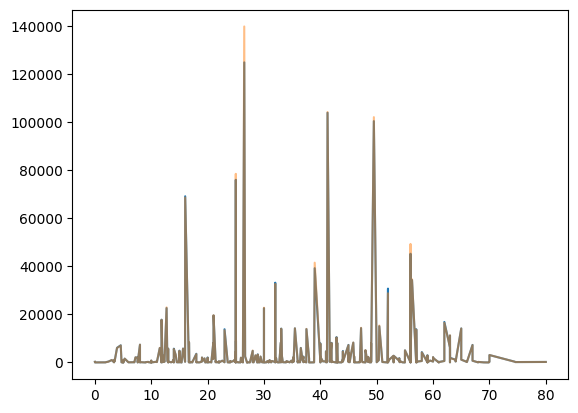

In [71]:
bf = "discount"
domain = X_train[bf].sort_values().drop_duplicates()
domain_index = domain.index
y_hat = rf_best_model.predict(X_train.loc[domain_index])
y = y_train.loc[domain_index.values]

plt.plot(domain.values, y_hat)
plt.plot(domain.values, y, alpha = 0.5)

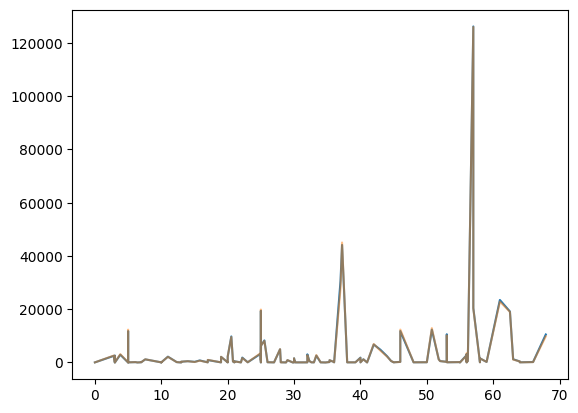

In [70]:
bf = "discount"
domain = X_test[bf].sort_values().drop_duplicates()
domain_index = domain.index
y_hat = rf_best_model.predict(X_test.loc[domain_index])
y = y_test.loc[domain_index.values]

plt.plot(domain.values, y_hat)
plt.plot(domain.values, y, alpha = 0.5)

## Shap

In [87]:
import shap

X_train_transformed = lgbm_best_model.named_steps['preprocessor'].transform(X_train)
lgbm_best_model_cv =lgbm_best_model.named_steps["model"]

# Crear un objeto Explainer para SHAP (LightGBM)
explainer_lgbm = shap.Explainer(lgbm_best_model_cv)
shap_values_lgbm = explainer_lgbm(X_train_transformed)

In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import shap

# Definir las características categóricas y numéricas
categorical_features = ['buying_mode', 'query', 'condition', 'brand', 'domain_id', 'listing_type_id']
numerical_features = ['price', 'initial_quantity', 'available_quantity', 'installment_quantity', 'installment_rate', 'days_until_discount_end', 'msi', 'discount']

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = lgbm_best_model

# Extraer el conjunto de datos transformado desde el pipeline
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

# Usar SHAP para calcular valores de SHAP
explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_train_transformed)

# Graficar SHAP summary
# shap.summary_plot(shap_values, X_train_transformed)


In [88]:
shap_values_lgbm

.values =
<1075x468 sparse matrix of type '<class 'numpy.float64'>'
	with 48375 stored elements in Compressed Sparse Row format>

.base_values =
array([2102.60186005, 2102.60186005, 2102.60186005, ..., 2102.60186005,
       2102.60186005, 2102.60186005])

.data =
<1075x468 sparse matrix of type '<class 'numpy.float64'>'
	with 16914 stored elements in Compressed Sparse Row format>

# Guardar los resultados

In [ ]:
best_rf_model = RandomForestRegressor(**best_rf_params)
best_xgb_model = XGBRegressor(**best_xgb_params)
best_lgbm_model = LGBMRegressor(**best_lgbm_params)

In [ ]:
import joblib

joblib.dump(best_rf_model, 'best_random_forest_model.pkl')
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')
joblib.dump(best_lgbm_model, 'best_lightgbm_model.pkl')